In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import deepmatcher as dm
import pandas as pd
import numpy as np
import torch

In [8]:
def getTrainValidationTest(dataset_path,leftPrefix,rightPrefix,selectedColumns):
    df = pd.read_json(dataset_path,lines=True,compression='gzip')
    new_col = {}
    for col in list(df):
        if col.endswith('_left'):
            tokens = col.split('_left',1)
            new_col[col]= leftPrefix+tokens[0]
        elif col.endswith('_right'):
            tokens = col.split('_right',1)
            new_col[col] = rightPrefix+tokens[0]
        else:
            new_col[col] = col
    new_col['pair_id'] = 'id'
    df = df.rename(columns = new_col)
    columns_to_drop = [col for col in list(df) if col not in selectedColumns]
    df = df.drop(columns = columns_to_drop)
    train, validation,test = np.split(df.sample(frac=1), [int(.6*len(df)),int(.8*len(df))])
    return train,validation,test,df

In [9]:
ignore_columns = ['id','ltable_title','ltable_description','ltable_price',
                  'rtable_title','rtable_description','rtable_price','label']
train_medium,validation_medium,test_medium,all_medium = getTrainValidationTest('computers_train_medium.json.gz',
                                                                               'ltable_','rtable_',
                                                                               selectedColumns=ignore_columns)

In [10]:
train_medium.to_csv('computer_train_medium.csv',index=False)
validation_medium.to_csv('computer_validation_medium.csv',index=False)
test_medium.to_csv('computer_test_medium.csv',index=False)

In [11]:
all_medium[all_medium.label==0].to_csv('computer_neg_medium.csv',index=False)
all_medium[all_medium.label==1].to_csv('computer_pos_medium.csv',index=False)

In [24]:
train,validation,test = getTrainValidationTest('computers_train_small.json.gz','ltable_','rtable_')

In [25]:
train_df.to_csv('computer_train_small.csv',index=False)
validation_df.to_csv('computer_validation_small.csv',index=False)
test_df.to_csv('computer_test_small.csv',index=False)

## Train model

In [34]:
train,validation,test = getTrainValidationTest('computers_train_medium.json.gz','ltable_','rtable_')
ignore_columns = ['pair_id','ltable_title','ltable_description','ltable_price',
                  'rtable_title','rtable_description','rtable_price','label']
columns_to_drop = [col for col in list(train) if col not in ignore_columns]
train_df = train.drop(columns =columns_to_drop)
validation_df = validation.drop(columns =columns_to_drop)
test_df = test.drop(columns = columns_to_drop)

In [35]:
train_df.to_csv('computer_train_medium.csv',index=False)
validation_df.to_csv('computer_validation_medium.csv',index=False)
test_df.to_csv('computer_test_medium.csv',index=False)

In [37]:
train,validation,test = dm.data.process('./',train='computer_train_medium.csv',validation='computer_validation_medium.csv',
                                        test='computer_test_medium.csv',ignore_columns=['ltable_id','rtable_id','pair_id'],
                                       left_prefix='ltable_',right_prefix='rtable_',cache='computers_medium.pth')

In [39]:
hybrid_model = dm.MatchingModel(attr_summarizer='rnn')
hybrid_model.run_train(train,validation,epochs=20,pos_neg_ratio=4,best_save_path='models/computer_hybrid.pth')

* Number of trainable parameters: 1762802
===>  TRAIN Epoch 1
Finished Epoch 1 || Run Time:   20.4 | Load Time:   52.7 || F1:  40.05 | Prec:  26.12 | Rec:  85.85 || Ex/s:  66.42

===>  EVAL Epoch 1
Finished Epoch 1 || Run Time:    2.0 | Load Time:   14.6 || F1:  54.19 | Prec:  41.73 | Rec:  77.25 || Ex/s:  97.92

* Best F1: 54.187192118226605
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2
Finished Epoch 2 || Run Time:   22.3 | Load Time:   58.1 || F1:  56.69 | Prec:  41.92 | Rec:  87.55 || Ex/s:  60.35

===>  EVAL Epoch 2
Finished Epoch 2 || Run Time:    2.0 | Load Time:   14.7 || F1:  61.06 | Prec:  49.56 | Rec:  79.49 || Ex/s:  96.77

* Best F1: 61.05717367853291
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3
Finished Epoch 3 || Run Time:   23.5 | Load Time:   64.8 || F1:  72.76 | Prec:  59.40 | Rec:  93.87 || Ex/s:  55.01

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    2.0 | Load Time:   14.8 || F1:  64.15 | Prec:  58.09 | Rec:  71.

69.09090909090908

In [40]:
hybrid_model.run_eval(test)

===>  EVAL Epoch 17
Finished Epoch 17 || Run Time:    2.5 | Load Time:   19.1 || F1:  64.48 | Prec:  66.67 | Rec:  62.43 || Ex/s:  75.18



64.47761194029852

## Compute rankings

In [4]:
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi

In [5]:
attributes =['title','description','price']

In [6]:
model = dm.MatchingModel(attr_summarizer='rnn')
model.load_state('models/computer_rnn.pth')
model = model.cuda()

In [15]:
negatives = return_layer_input(model,model.classifier,'./','computer_neg_medium')

In [16]:
positives = return_layer_input(model,model.classifier,'./','computer_pos_medium')

In [17]:
classifier_len = len(list(positives.values())[0])
attribute_len = int(classifier_len/len(attributes))

In [20]:
negatives_ri,neg_ri_norms = computeRi(model.classifier,attributes,negatives,attribute_len,1)
torch.save(negatives_ri,'neg_ri.pt')

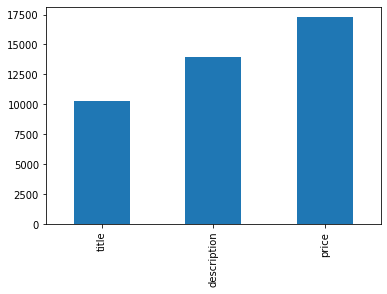

In [22]:
neg_variation_df = pd.DataFrame(data=neg_ri_norms,columns=attributes)
neg_variation_df.sum().plot.bar()

In [23]:
positives_ri,pos_ri_norms = computeRi(model.classifier,attributes,positives,attribute_len,0)
torch.save(negatives_ri,'pos_ri.pt')

100%|██████████| 1762/1762 [00:15<00:00, 111.45it/s]


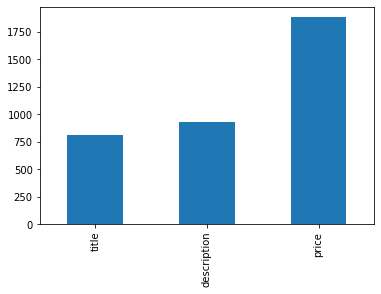

In [24]:
pos_variation_df = pd.DataFrame(data=pos_ri_norms,columns=attributes)
pos_variation_df.sum().plot.bar()